# Deep Hedging

You will see in this notebook

In [1]:
import os
import scipy.stats as stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

%matplotlib inline

# Problem formulation and Input Data

We investigate the problem of hedging a Call where the underlying can only be traded with a relative bid-ask spread, i.e. if you by the underlying you have to pay
$$S_{bid}=s\dot S_{mid}$$ and if you sell 

In [2]:
vol = 0.2
strike = 100.0
spot = 100.0
ba_spread = 0.00
ttm = 1.0

In [3]:
def compute_data(ttm, n_timesteps, n_samples, final_payoff, vol, spot, ba_spread):
    """ This method simulates bid-ask spot paths using geometric brownian motion and returns 
    the path together with the evaluation of a given payoff at the final simulation date.
    Args:
        ttm (float): The time-to-maturity of the simulation
        n_timesteps (int): Number of timesteps used to simulate the paths
        n_samples (int): Number of monte carlo simulations
        final_payoff (function): Function that is evaluated at the final spot values
        vol: The volatility of the geometric brownian motion (annualized)
        ba_spread: Bid-ask spread as percentage, i.e. spot_bid = spot*(1.0-ba_spread*0.5)

    Returns:
        [3D numpy-array]: The spot bid value
        [3D numpy-array]: The spot ask value
        [3D numpy-array]: Timegrid (of time-to-maturities)
        [3D numpy-array]: Evaluated payoff (at maturity)
    """
    spot_bid = np.empty((n_samples, n_timesteps,))
    spot_ask = np.empty((n_samples, n_timesteps,))
    payoff = np.zeros((n_samples,n_timesteps,))
    timegrid = np.linspace(0.0, ttm, n_timesteps)
    call_ttm = np.empty((n_samples, n_timesteps,))
    simulated_spot = np.full((n_samples,), spot)
    spot_bid[:,0] = simulated_spot*(1.0-ba_spread*0.5)
    spot_ask[:,0] = simulated_spot*(1.0+ba_spread*0.5)
    
    for i in range(n_samples):
        call_ttm[i,:] = ttm-timegrid
    
    vol_2 = vol**2
    for i in range(1,timegrid.shape[0]):
        dt = timegrid[i]-timegrid[i-1]
        rand = np.random.standard_normal((n_samples,))
        simulated_spot = simulated_spot * np.exp((- 0.5 * vol_2) * dt +
                                         vol * np.sqrt(dt) * rand)
        spot_bid[:,i] = simulated_spot*(1.0-ba_spread*0.5)
        spot_ask[:,i] = simulated_spot*(1.0+ba_spread*0.5)
    payoff[:,-1] = final_payoff(simulated_spot)
    return np.atleast_3d(spot_bid), np.atleast_3d(spot_ask), np.atleast_3d(call_ttm), np.atleast_3d(payoff)

def call_payoff(strike):
    """Defines the call payoff function for a call with strike strike.
    """
    def c(x):
        return np.maximum(x-strike, 0.0)
    return c


spot_bid, spot_ask, call_ttm, payoff = compute_data(ttm, n_timesteps=120, n_samples=20000, 
                                                    final_payoff=call_payoff(strike=strike), vol=vol, 
                                                    spot=spot, ba_spread=ba_spread)


f_hedge=np.concatenate([(spot_bid+spot_ask)/(2.0*strike), call_ttm], axis=2)

In [4]:
if False:
    selection = (spot_bid[:,-1,0]>140.0) | (spot_bid[:,-1,0] < 0.6)
    spot_bid_sel = spot_bid[selection]
    spot_ask_sel = spot_ask[selection]
    call_ttm_sel = call_ttm[selection]
    payoff_sel = payoff[selection]
    f_hedge_sel=np.concatenate([(spot_bid_sel+spot_ask_sel)/(2.0*strike), call_ttm_sel], axis=2)

# Creating the network

In [5]:
class Hedger:
    
    @staticmethod
    def get_hedge_model(m, name_time_distributed = None):
        if name_time_distributed is None:
            name_time_distributed = 'time_distributed/hedge_model'
        return m.get_layer(name_time_distributed).layer
        
    
    @staticmethod
    def _create_hedge_model(n_features,layers=[{'units':10, 'activation':'tanh'}, {'units':5, 'activation':'tanh'}, {'units':1, 'activation':'linear'}]):
        hedge_input_feat = tf.keras.layers.Input(shape=(n_features), ragged=False, name='hedge_input')
        previous = tf.keras.layers.Dense(name='hedge_model_0', **layers[0])(hedge_input_feat)
        for k in range(1, len(layers)):
            if k < len(layers)-1:
                name = 'hedge_model_'+str(k)
            else:
                name = 'hedge_qty'
            previous = tf.keras.layers.Dense(name = name, **layers[k])(previous)
        return tf.keras.models.Model(name = 'hedge_model', inputs=hedge_input_feat, 
                              outputs=previous)
        return previous
        
    @staticmethod
    def create_model(n_times, n_features,
                     layers=[{'units':10, 'activation':'tanh'}, {'units':5, 'activation':'tanh'}, {'units':1, 'activation':'linear'}]):
        # create hedge model
        #
        hedge_input_feat = tf.keras.layers.Input(shape=(n_times-1, n_features), ragged=False, name='hedge_input')
        hedge_model = Hedger._create_hedge_model(n_features, layers)
        cf_input_hedge_qty = tf.keras.layers.TimeDistributed(hedge_model, name='time_distributed/hedge_model')(hedge_input_feat)
            
        # In our example, the loss function in the training will be applied the PnL of the hedging strategy on each path.
        # The PnL computation is done in the following lines.
        #
        cf_input_spot_bid = tf.keras.Input(shape=(n_times,1) ,name='CF_input_spot_bid')
        cf_input_spot_ask = tf.keras.Input(shape=(n_times,1) ,name='CF_input_spot_ask')
        
        cf_input_inst_payoff = tf.keras.Input(shape=(n_times,1) ,name='CF_input_call_payoff')
        cf_input_df = tf.keras.Input(shape=(n_times,1) ,name='CF_input_df')

        # hedge cashflows from trades
        cf_dqty_inner = tf.keras.layers.Lambda(lambda x: x[:,1:] - x[:,:-1])(cf_input_hedge_qty)
        cf_dqty0 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(x[:,0,:], shape=(-1,1,1)))(cf_input_hedge_qty)
        cf_dqtyT = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(-x[:,-1,:], shape=(-1,1,1)))(cf_input_hedge_qty)
        cf_dqty = tf.keras.layers.Concatenate(axis=1)([cf_dqty0, cf_dqty_inner, cf_dqtyT])

        cf_dqty_pos = tf.keras.layers.Lambda(lambda x: tf.keras.backend.minimum(-1.0*x, 0.0))(cf_dqty)
        cf_dqty_neg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.maximum(-1.0*x, 0.0))(cf_dqty)

        cf_hedge_cashflow_buy = tf.keras.layers.Multiply()([cf_dqty_pos, cf_input_spot_ask])
        cf_hedge_cashflow_sell = tf.keras.layers.Multiply()([cf_dqty_neg, cf_input_spot_bid])
        cf_hedge_cashflow = tf.keras.layers.Add(name='CF_hedge_cashflow_trades')([cf_hedge_cashflow_buy, cf_hedge_cashflow_sell])

        # all cashflows collected
        cf_cashflow = tf.keras.layers.Add(name='CF_cashflow_total')([cf_input_inst_payoff, cf_hedge_cashflow])
        # discounted cashflow defines the loss
        cf_loss_timestep = tf.keras.layers.Multiply(name='CF_cashflows_discounted')([cf_input_df, cf_cashflow])
        # aggregate loss output (over time steps)
        cf_loss_value = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1, keepdims=True), name='loss')(cf_loss_timestep)
        
        # return total model
        return tf.keras.models.Model(inputs=[hedge_input_feat, cf_input_spot_bid, cf_input_spot_ask, cf_input_inst_payoff, cf_input_df], 
                              outputs=cf_loss_value)

# Creation and Training

In [6]:
nn_hedge = Hedger.create_model(120, f_hedge.shape[-1], layers = [{'units':10, 'activation':'tanh'}, 
                                                             {'units':5, 'activation':'tanh'}, 
                                                             {'units':1, 'activation':'linear'}])

In [7]:
@tf.function
def variance_loss(y_true, y_pred):
    x = tf.nn.moments(y_pred, axes=0)
    return x[1]


@tf.function
def expected_shortfall_10pct(y_true, y_pred):
    """[summary]

    Args:
        y_true ([type]): [description]
        y_pred ([type]): [description]

    Returns:
        [type]: [description]
    """
    pnl = tf.keras.backend.reshape(y_pred - y_true, (-1, ))
    pnl = tf.multiply(pnl, -1.0)

    n_pct = tf.keras.backend.round(tf.multiply(
        tf.keras.backend.cast(tf.keras.backend.shape(pnl)[0], tf.float32)  , 0.1))

    pnl_past_cutoff = tf.nn.top_k(pnl, tf.keras.backend.cast(n_pct, tf.int32))[0]
    return tf.reduce_mean(pnl_past_cutoff)

In [8]:
nn_hedge.compile( optimizer = tf.keras.optimizers.Adam(lr=0.0025, beta_1=0.9, beta_2=0.999), loss = variance_loss)#'mean_squared_error')

In [9]:
df = np.ones(shape=(f_hedge.shape[0], f_hedge.shape[1], 1))# set discount factors to 1 (no discounting)
y = np.zeros((f_hedge.shape[0], ))

In [10]:
# if you would like to use the tensorboard, uncomment the following lines and adjust the directories accordingly
date = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'C:\\temp\\deep_hedging\\' + date
cb = [tf.keras.callbacks.TensorBoard(profile_batch=0, 
                            log_dir=log_dir, histogram_freq=100),]
cb.append(tf.keras.callbacks.ModelCheckpoint('model_5_percent_spread.h5', save_best_only = True))

In [11]:
if False:
    def scheduler(epoch):
            base_lr = 0.05
            if epoch<2000:
                return 1.0*base_lr
            elif epoch<80:
                return 1.0*base_lr
            elif epoch<160:
                return 0.5*base_lr
            return 0.25*base_lr
    cb.append(tf.keras.callbacks.LearningRateScheduler(
        scheduler, verbose=0
    ))


In [12]:
history = nn_hedge.fit([f_hedge[:,:-1,:], spot_bid, spot_ask, payoff, df], 
                    y, verbose=0,
                    epochs=100,
                    batch_size=100,
                    callbacks=cb,
                    validation_split=0.2)

# Model analysis

In this section, we analyze the behaviour of our deep hedging model. For this, we load two different models: One which has been calibrated with 0% bid-ask spread and one with 5% spread. Note that you can simply read two different cases

In [13]:
def compute_bs(spot, strike, ttm, sigma, r):
    d1 = ( np.log(spot / strike) + (r + 0.5*sigma**2) * ttm ) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    price = spot * stats.norm.cdf(d1) - np.exp(-r * ttm) * strike * stats.norm.cdf(d2)
    delta = stats.norm.cdf(d1)
    return price, delta

In [15]:
nn_hedge = tf.keras.models.load_model('model_5_percent_spread.h5', custom_objects={'variance_loss':variance_loss, 
                                                                                   'expected_shortfall_10pct': expected_shortfall_10pct})

BS price: 7.965567455405804
Mean pnl hedged portfolio: 7.952026346974864  variance hedged portfolio: 0.634244371146224
Mean payoff: 7.94368662448287, variance payoff: 175.819801375998


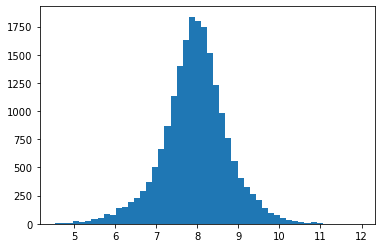

In [21]:
pnl = nn_hedge.predict([f_hedge[:,:-1,:], spot_bid, spot_ask,  payoff, df[:]])#
plt.hist(pnl[:,0,0], bins=50)
#plt.hist(payoff[:,-1,0], bins=50)
np.var(pnl[:,0,0])
#np.var(payoff[:,-1,0])
bs_price, _ = compute_bs(spot, strike, ttm, vol, 0.0)
print('BS price: ' + str(bs_price))
print('Mean pnl hedged portfolio: ' + str(np.mean(pnl[:,0,0])), ' variance hedged portfolio: ' + str(np.var(pnl[:,0,0])))
print('Mean payoff: ' + str(np.mean(payoff[:,-1,0])) + ', variance payoff: ' + str(np.var(payoff[:,-1,0])))



In [18]:
hedge_model = Hedger.get_hedge_model(nn_hedge)

In [19]:
def plot_delta_vs_spot(model, ttm):
    spots = np.arange(0.5*spot,1.5*spot, 0.01*spot)
    x=np.empty(shape=(spots.shape[0], 2))
    x[:,0] = spots/strike
    x[:,1] = ttm
    delta = hedge_model.predict(x)
    plt.plot(spots,-delta[:,0],'.', label='Deep Hedging') #since the above model hedges a long Call position, we have to use -delta to compare with BS delta
    # now compute and plot reference delta
    bs_delta = np.empty(shape=(spots.shape[0]))
    for i,s in enumerate(spots):
        _, bs_delta[i] = compute_bs(s, strike, ttm, vol, 0.0)
    plt.plot(spots,bs_delta,'.', label='Black-Scholes')
    plt.legend()
    plt.xlabel('spot')
    plt.ylabel('delta')
    plt.title('Black-Scholes vs Deep Hedging Delta for Call with ttm=' + str(ttm))
    
def plot_delta_vs_ttm(model, spot):
    ttm_ = np.arange(0.0, ttm, 1.0/365.0)
    x=np.empty(shape=(ttm_.shape[0], 2))
    x[:,0] = spot/strike
    x[:,1] = ttm_
    delta = hedge_model.predict(x)
    plt.plot(ttm_,-delta[:,0],'.', label='Deep Hedging') #since the above model hedges a long Call position, we have to use -delta to compare with BS delta
    # now compute and plot reference delta
    bs_delta = np.empty(shape=(ttm_.shape[0]))
    for i,t in enumerate(ttm_):
        _, bs_delta[i] = compute_bs(spot, strike, t, vol, 0.0)
    plt.plot(ttm_, bs_delta,'.', label='Black-Scholes')
    plt.legend()
    plt.xlabel('ttm')
    plt.ylabel('delta')
    plt.title('Black-Scholes vs Deep Hedging Delta for Call for spot=' + str(spot))

C:\Users\Anwender\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


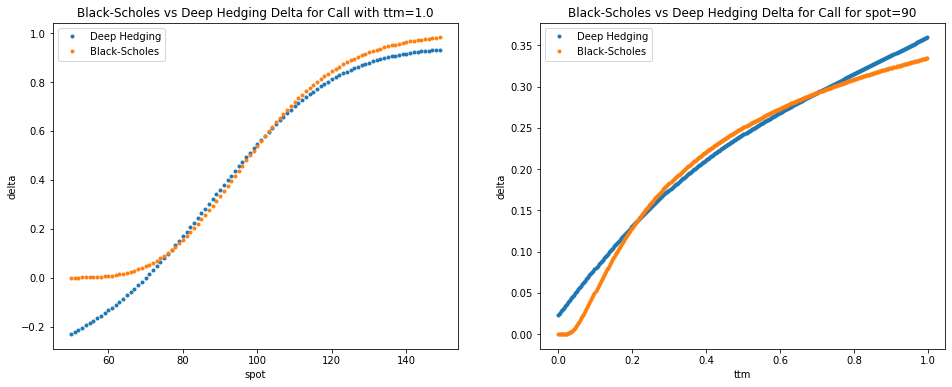

In [20]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_delta_vs_spot(hedge_model, ttm=1.0)
plt.subplot(1,2,2)
plot_delta_vs_ttm(hedge_model, spot=90)